In [18]:
# Carrega os dados

import pandas as pd

df_it = pd.read_csv("data/ITSecurity.csv")
df_se = pd.read_csv("data/SE.csv")
df_stack_1 = pd.read_csv("data/SO<2016.csv")
df_stack_2 = pd.read_csv("data/SO=2016.csv")
df_stack_3 = pd.read_csv("data/SO>2016.csv")

df_it['File'] = 'ITSec'
df_se['File'] = 'SE'
df_stack_1['File'] = 'SO'
df_stack_2['File'] = 'SO'
df_stack_3['File'] = 'SO'

df_combined = pd.concat([df_it, df_se, df_stack_1, df_stack_2, df_stack_3], axis=0)


In [19]:
# Faz a limpeza das palavras e define algumas colunas

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('all')
stop_words = set(stopwords.words('english'))

additional_stopwords = (['using', 'working', 'like', 'could', 'set', 'change', 
                        'value', 'get', '2', 'load', 'getting', 'new', 'use', 
                        'filter', '6', '5', '1', '3'])

stop_words.update(additional_stopwords)

def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.isalnum()
                      and word.lower() not in stop_words]
    return ' '.join(filtered_words)

df_combined['processed_text'] = df_combined['Title'].apply(preprocess_text)
df_combined['CreationDate'] = pd.to_datetime(df_combined['CreationDate'])
df_combined = df_combined.sort_values(by='CreationDate')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/emily/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /home/emily/nltk_data

In [20]:
# Adiciona a coluna de tags

import re

def extract_tags(tag_data):
    tags = re.findall(r'<(.*?)>', tag_data)
    return tags

df_combined['Tags'] = df_combined['Tags'].apply(extract_tags)

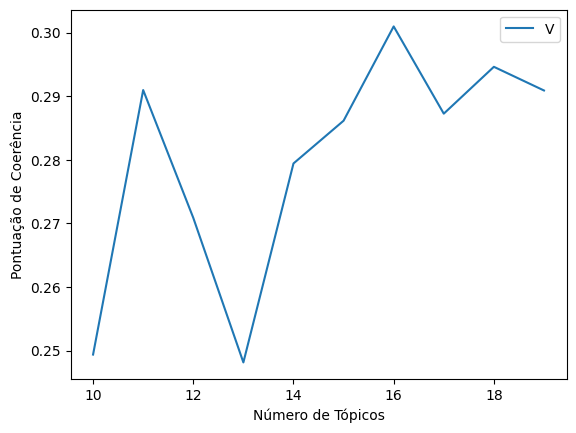

Número de Tópicos = 10, Pontuação de Coerência = 0.2494
Número de Tópicos = 11, Pontuação de Coerência = 0.2910
Número de Tópicos = 12, Pontuação de Coerência = 0.2709
Número de Tópicos = 13, Pontuação de Coerência = 0.2481
Número de Tópicos = 14, Pontuação de Coerência = 0.2794
Número de Tópicos = 15, Pontuação de Coerência = 0.2861
Número de Tópicos = 16, Pontuação de Coerência = 0.3010
Número de Tópicos = 17, Pontuação de Coerência = 0.2872
Número de Tópicos = 18, Pontuação de Coerência = 0.2946
Número de Tópicos = 19, Pontuação de Coerência = 0.2909


In [4]:
# Gera a quantidade de tópicos

import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel

texts = [text.split() for text in df_combined['processed_text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

def compute_coherence_score(num_topics):
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    df_combined['topic_assignment'] = [max(lda.get_document_topics(dictionary.doc2bow(text.split())), key=lambda x: x[1])[0] + 1 for text in df_combined['processed_text']]
    
    coherence_model = CoherenceModel(model=lda, texts=df_combined['processed_text'].apply(lambda x: x.split()), coherence='c_v')
    coherence = coherence_model.get_coherence()

    # topics = lda.print_topics(num_topics=num_topics)
    # for topic in topics:
    #     print(topic)
    # print('\n')
    
    return coherence

limit = 20
start = 10
step = 1
x = range(start, limit, step)
coherence_scores = []

for num_topics in x:
    coherence_score = compute_coherence_score(num_topics)
    coherence_scores.append(coherence_score)

plt.plot(x, coherence_scores)
plt.xlabel("Número de Tópicos")
plt.ylabel("Pontuação de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

for num_topics, score in zip(x, coherence_scores):
    print(f"Número de Tópicos = {num_topics}, Pontuação de Coerência = {score:.4f}")


In [21]:
# Pega as palavras do número de tópicos escolhido

num_topics = 16

def get_top_words_per_topic(model, n_words=10):
    topic_words = []
    for topic_id in range(model.num_topics):
        words = model.show_topic(topic_id, topn=n_words)
        top_words = [word[0] for word in words]
        topic_words.append(top_words)
    return topic_words

lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
df_combined['topic_assignment'] = [max(lda.get_document_topics(dictionary.doc2bow(text.split())), key=lambda x: x[1])[0] + 1 for text in df_combined['processed_text']]

topics = get_top_words_per_topic(lda, n_words=10)

for i, words in enumerate(topics):
    print(f"Topic {i+1}: {', '.join(words)}")

result_df = df_combined[['Title', 'topic_assignment', 'File', 'CreationDate']]
df_combined.head(20)

Topic 1: authorization, java, allow, test, certificate, trying, network, forbidden, different, domain
Topic 2: string, ip, query, instead, js, message, address, logged, json, resolve
Topic 3: api, key, rest, public, issue, access, gateway, object, permission, problem
Topic 4: token, jwt, resource, custom, access, safe, basic, path, javascript, make
Topic 5: authentication, http, unable, disable, call, https, cookie, default, local, always
Topic 6: secure, way, rule, one, response, redirect, ca, script, chrome, project
Topic 7: app, password, google, store, csrf, python, securely, validation, username, send
Topic 8: spring, security, boot, oauth2, authentication, request, login, custom, endpoint, oauth
Topic 9: rules, firebase, firestore, security, data, database, android, cloud, post, form
Topic 10: prevent, header, file, php, files, protect, connect, controller, return, tokens
Topic 11: client, service, web, credentials, type, missing, inside, image, application, pass
Topic 12: user, 

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense,File,processed_text,topic_assignment
377,328,1,7488.0,NaN,2008-08-02 02:41:34,NaN,125,85677,<p>What are some guidelines for maintaining re...,59.0,...,"[security, php]",13,0,0.0,NaN,NaN,CC BY-SA 3.0,SO,php session security,8
378,549,1,477578.0,NaN,2008-08-02 19:51:50,NaN,5518,677127,<blockquote>\n<h4>Moderator note:</h4>\n<p>Thi...,136.0,...,"[forms, http, security, authentication, langua...",11,16,0.0,2016-08-11 07:19:48,2008-10-01 00:39:14,CC BY-SA 4.0,SO,definitive guide website authentication,5
379,2447,1,NaN,NaN,2008-08-05 15:05:00,NaN,11,714,"<p>Regarding Agile development, what are the b...",NaN,...,"[security, agile]",4,0,0.0,2017-11-07 17:40:56,NaN,CC BY-SA 3.0,SO,best practices testing security agile developm...,15
380,2525,1,8739.0,NaN,2008-08-05 16:20:37,NaN,165,151118,"<p>My product has several components: ASP.NET,...",350.0,...,"[.net, security, obfuscation]",30,5,0.0,2014-03-06 03:08:35,2011-07-19 20:03:17,CC BY-SA 3.0,SO,obfuscation,11
381,2688,1,2741.0,NaN,2008-08-05 18:45:46,NaN,21,3513,"<p>When you execute a SQL query, you have to c...",432.0,...,"[mysql, oracle, security]",11,1,NaN,NaN,NaN,CC BY-SA 3.0,SO,need escape sending query,10
382,2970,1,2976.0,NaN,2008-08-05 23:55:25,NaN,23,4278,<p>My dad called me today and said people goin...,58.0,...,"[security, cracking]",8,2,0.0,2012-03-06 03:17:01,NaN,CC BY-SA 3.0,SO,website got hacked,5
383,3027,1,NaN,NaN,2008-08-06 02:36:23,NaN,21,2638,<p>What is the best unobtrusive CAPTCHA for we...,439.0,...,"[security, usability, captcha]",5,1,0.0,NaN,NaN,CC BY-SA 2.5,SO,unobtrusive captcha web forms,5
384,3486,1,3827.0,NaN,2008-08-06 14:44:09,NaN,5,2324,<p>I have control over the HttpServer but not ...,527.0,...,"[security, apache, mod-rewrite, http-referer]",9,0,NaN,NaN,NaN,CC BY-SA 3.0,SO,block user access internals site,12
387,5078,1,5108.0,NaN,2008-08-07 18:10:17,NaN,21,4058,<p>I'd like to set up a cheap Linux box as a w...,318.0,...,"[linux, security, webserver]",12,0,0.0,NaN,NaN,CC BY-SA 3.0,SO,securing linux webserver public access,3
389,5611,1,5820.0,NaN,2008-08-08 03:18:56,NaN,22,8257,<p>I know that just using <code>rand()</code> ...,115.0,...,"[php, security, random]",6,1,0.0,NaN,NaN,CC BY-SA 3.0,SO,better random generating php,10


In [5]:
import gensim
import numpy as np
from sklearn.cluster import KMeans
import gensim.downloader as api

# Load a pre-trained Word2Vec model (you can use your own if available)
# Make sure the dimensions of the Word2Vec model match your data (e.g., 100, 200, 300)
model = api.load("word2vec-google-news-300")

# Função para calcular o centróide de um conjunto de vetores de palavras
def calculate_topic_centroid(topic_words, word_vectors):
    vectors = [word_vectors[word] for word in topic_words if word in word_vectors]
    if not vectors:
        return None
    centroid = np.mean(vectors, axis=0)
    return centroid

# Calcular centróides para cada tópico
topic_centroids = []
for topic_words in topics:
    centroid = calculate_topic_centroid(topic_words, model)
    if centroid is not None:
        topic_centroids.append(centroid)

# Usar clustering K-means para encontrar rótulos para os tópicos
num_clusters = len(topic_centroids)
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(topic_centroids)

# Escolher a palavra mais próxima ao centróide como rótulo para cada tópico
topic_representative_labels = []
for i in range(num_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_words = [word for index in cluster_indices for word in topics[index] if word in model]
    if cluster_words:
        similarities = [np.dot(model[word], topic_centroids[i]) for word in cluster_words]
        if similarities:
            nearest_words = [cluster_words[idx] for idx in np.argsort(similarities)[::-1]]
            topic_representative_labels.append(nearest_words)
        else:
            topic_representative_labels.append("No Label Found")
    else:
        topic_representative_labels.append("No Label Found")

topic_labels = []
# Imprimir os rótulos representativos para os tópicos
for label, topic_label in enumerate(topic_representative_labels):
    print(f"Topic {label}: {topic_label}")
    topic_labels.append(topic_label)


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Topic 0: ['database', 'data', 'rules', 'cloud', 'security', 'android', 'form', 'firebase', 'post']
Topic 1: ['login', 'authentication', 'endpoint', 'request', 'boot', 'custom', 'security', 'spring']
Topic 2: ['application', 'service', 'credentials', 'image', 'client', 'web', 'type', 'pass', 'inside', 'missing']
Topic 3: ['username', 'password', 'app', 'google', 'securely', 'validation', 'send', 'store', 'python']
Topic 4: ['ip', 'js', 'query', 'logged', 'address', 'message', 'json', 'resolve', 'instead', 'string']
Topic 5: ['parameter', 'server', 'auth', 'need', 'requests', 'securing', 'storage', 'connection', 'adding']
Topic 6: ['code', 'check', 'account', 'access', 'security', 'specific', 'implement', 'azure', 'aws', 'running']
Topic 7: ['php', 'tokens', 'files', 'header', 'file', 'controller', 'protect', 'connect', 'prevent', 'return']
Topic 8: ['https', 'authentication', 'http', 'cookie', 'disabl

/home/emily/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
# Cria os arquivos

num_topics = 16
output_file = "topics.txt"
output_file_details = "topics-with-details.txt"
output_file_tags = "topics-with-tags.txt"

gpt_labels_1 = [
    "Autorização e Certificados Java",
    "Manipulação de Strings e Consultas IP", 
    "APIs, Chaves e Problemas de Acesso", 
    "Tokens, JWT e Segurança de Recursos",
    "Autenticação, HTTP e Cookies", 
    "Regras de Segurança e Respostas", 
    "Aplicativos, Senhas e Validação", 
    "Spring Security, OAuth2 e Autenticação",  
    "Regras de Firebase e Firestore",
    "Prevenção, PHP e Controle de Arquivos", 
    "Clientes, Serviços e Credenciais", 
    "Usuários, Acesso e Funções", 
    "Código, AWS e Segurança Específica", 
    "Páginas, Vulnerabilidades e Sessões",
    "Servidores, Autenticação e Armazenamento", 
    "Erros, Políticas de Segurança e Funções"
]

gpt_labels = [
    "Gerenciamento de Dados em Nuvem",
    "Autenticação e Segurança de Aplicações",
    "Integração de Serviços e Autenticação",
    "Segurança de Senhas e Armazenamento de Credenciais",
    "Manipulação de Dados em JavaScript",
    "Segurança de Conexões e Autenticação de Servidor",
    "Segurança de Contas e Acesso a Serviços em Nuvem",
    "Segurança em Aplicações PHP",
    "Segurança de Comunicações Web",
    "Autorização em Java e Certificados",
    "Gerenciamento de Permissões e Autenticação em Documentos",
    "Autenticação Baseada em Funções de Usuário",
    "Segurança e Acesso em JavaScript",
    "Certificados e Redirecionamento em Scripts",
    "Erros de Segurança e Políticas de Conteúdo",
    "Problemas de Acesso e Segurança em APIs"
]

with open(output_file, 'w') as file:
    for topic_num, topic in enumerate(lda.print_topics(num_topics=num_topics), start=1):
        words = topic[1].split('+')
        
        topic_text = ', '.join(word.split('*')[1].strip().strip('"') for word in words)
        formatted_topic = f"Topic {gpt_labels[topic_num - 1]}: {topic_text}\n"
        file.write(formatted_topic)

with open(output_file_details, 'w') as file:
    file.write(df_combined[['Title', 'topic_assignment',
                            'File', 'CreationDate']].to_string(index=False))

with open(output_file_tags, 'w') as file:
    file.write(df_combined[['Tags', 'topic_assignment', 'File']].to_string(index=False))


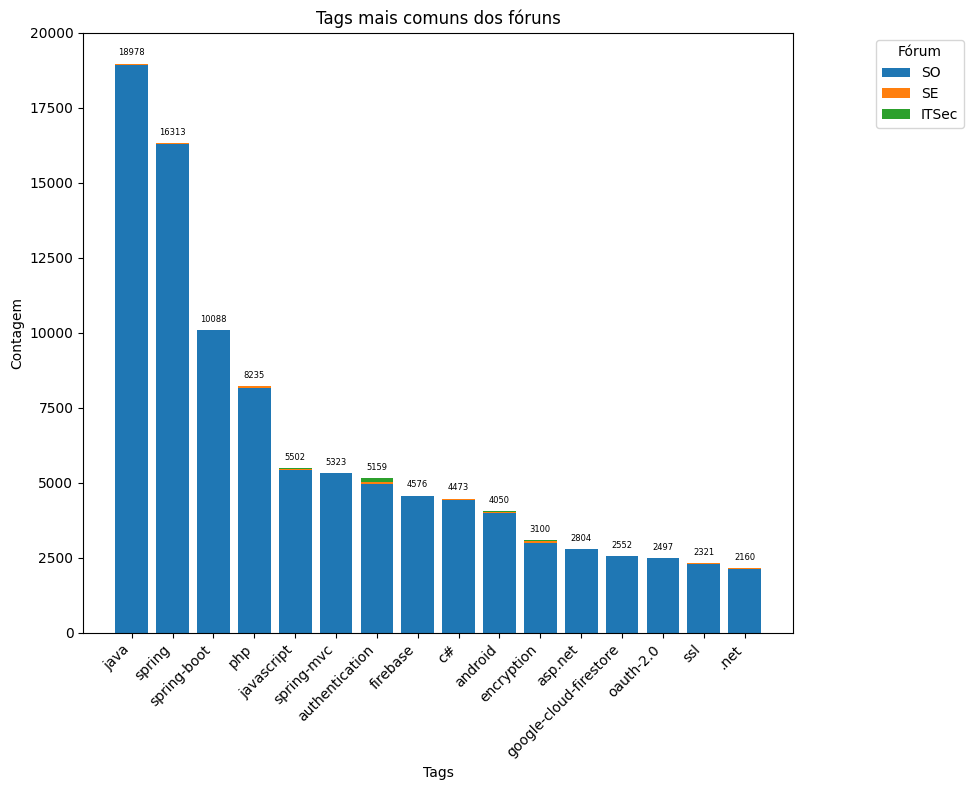

In [23]:
# Imagem das 15 tags mais comuns entre os fóruns

import pandas as pd
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt

tag_counts_by_topic = Counter()
tag_counts_by_forum = defaultdict(Counter)

total_tag_count = 0

excluded_words = ['security']

for index, row in df_combined.iterrows():
    topic = row['topic_assignment']
    tags = row['Tags']
    forum = row['File']

    for tag in tags:
        if not any(word in tag for word in excluded_words):
            tag_counts_by_topic[tag] += 1
            tag_counts_by_forum[forum][tag] += 1
            total_tag_count += 1

max_tags_to_display = 16

top_tags = tag_counts_by_topic.most_common(max_tags_to_display)
tags = [tag[0] for tag in top_tags]
counts = [tag[1] for tag in top_tags]
forum_counts = {forum: [forum_count[tag] for tag in tags] for forum, forum_count in tag_counts_by_forum.items()}

fig, ax = plt.subplots(figsize=(10, 8))
x = range(len(tags))

bottom = [0] * len(tags)
total_forum_counts = [0] * len(tags)

for forum, forum_count in forum_counts.items():
    bars = ax.bar(tags, forum_count, label=forum, bottom=bottom)
    total_forum_counts = [total_forum_counts[i] + forum_count[i] for i in range(len(tags))]
    bottom = [bottom[i] + count for i, count in enumerate(forum_count)]

for tag, total_count in zip(tags, total_forum_counts):
    ax.annotate(total_count, xy=(tags.index(tag), total_count), xytext=(0, 6), textcoords='offset points', ha='center', fontsize=6)

ax.set_xlabel('Tags')
ax.set_ylabel('Contagem')
ax.set_title('Tags mais comuns dos fóruns')
ax.legend(title='Fórum', loc='upper right', bbox_to_anchor=(1.25, 1))

ax.set_ylim(0, 20000)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [25]:
 # Exibe as 15 tags mais usadas em cada fórum

max_tags_to_display = 5
excluded_words = ['security']

import pandas as pd
from collections import Counter

tag_counts_by_topic_forum = {}

for index, row in df_combined.iterrows():
    tags = row['Tags']
    forum = row['File']
    topic = row['topic_assignment']

    if topic not in tag_counts_by_topic_forum:
        tag_counts_by_topic_forum[topic] = {}

    if forum not in tag_counts_by_topic_forum[topic]:
        tag_counts_by_topic_forum[topic][forum] = Counter()

    for tag in tags:
        if not any(word in tag for word in excluded_words):
            tag_counts_by_topic_forum[topic][forum][tag] += 1

sorted_topics = sorted(tag_counts_by_topic_forum.keys())

for topic in sorted_topics:
    print(f"Tópico {topic}:")
    forum_counts = tag_counts_by_topic_forum[topic]
    for forum, tag_counts in forum_counts.items():
        print(f"  Fórum: {forum}")
        top_tags = tag_counts.most_common(max_tags_to_display) 
        for tag, count in top_tags:
            print(f"    {tag}: {count} vezes")
        print()


Tópico 1:
  Fórum: SO
    java: 1550 vezes
    spring: 501 vezes
    spring-boot: 334 vezes
    c#: 301 vezes
    ssl: 298 vezes

  Fórum: SE
    authentication: 7 vezes
    authorization: 5 vezes
    ssl: 4 vezes
    microservices: 4 vezes
    rest: 3 vezes

  Fórum: ITSec
    network: 7 vezes
    waf: 5 vezes
    web-application: 5 vezes
    passwords: 4 vezes
    malware: 4 vezes

Tópico 2:
  Fórum: SO
    java: 423 vezes
    php: 305 vezes
    javascript: 228 vezes
    spring: 219 vezes
    c#: 141 vezes

  Fórum: SE
    passwords: 5 vezes
    java: 3 vezes
    email: 3 vezes
    hacking: 2 vezes
    validation: 2 vezes

  Fórum: ITSec
    email: 7 vezes
    passwords: 6 vezes
    ip: 6 vezes
    authentication: 5 vezes
    privacy: 5 vezes

Tópico 3:
  Fórum: SO
    java: 838 vezes
    rest: 427 vezes
    encryption: 409 vezes
    spring: 372 vezes
    api: 334 vezes

  Fórum: SE
    api: 21 vezes
    rest: 18 vezes
    encryption: 9 vezes
    authentication: 9 vezes
    architect

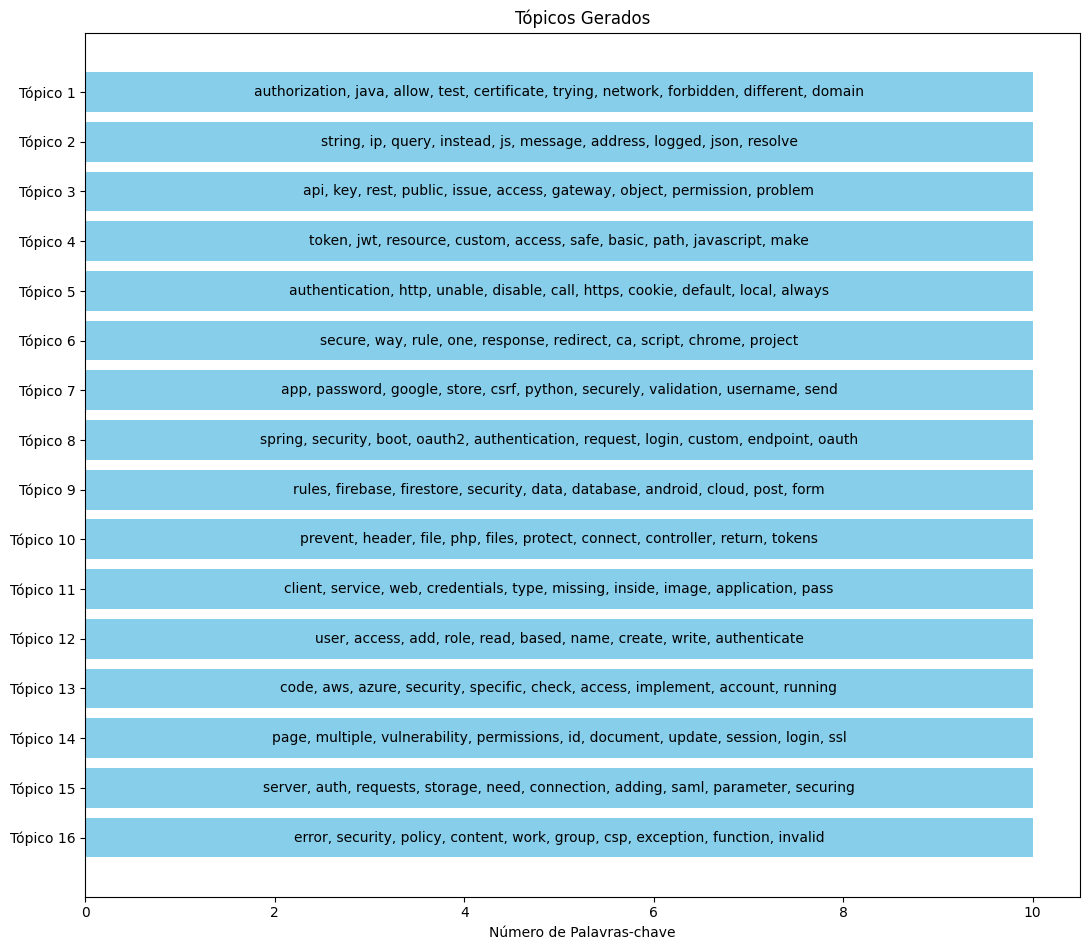

In [26]:
import matplotlib.pyplot as plt

topics = []
with open(output_file, "r", encoding="utf-8") as file:
    lines = file.readlines()
    for line in lines:
        topics.append(line.strip())

topic_keywords = [topic.split(": ")[1].split(", ") for topic in topics]

max_words = max(len(keywords) for keywords in topic_keywords)
fig_width = max_words + 1
fig_height = len(topic_keywords) * 0.6

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

for i, keywords in enumerate(topic_keywords):
    ax.barh(i, len(keywords), color='skyblue')
    text_x = len(keywords) / 2
    ax.text(text_x, i, ", ".join(keywords), ha='center', va='center', color='black')

ax.set_yticks(range(len(topic_keywords)))
ax.set_yticklabels([f'Tópico {i+1}' for i in range(len(topic_keywords))])
ax.invert_yaxis()
ax.set_xlabel('Número de Palavras-chave')
ax.set_title('Tópicos Gerados')

plt.tight_layout()
plt.show()


[5518, 3065, 5320, 4612, 4725, 5645, 6543, 21732, 8617, 6579, 5735, 6013, 5641, 4752, 3651, 6773]


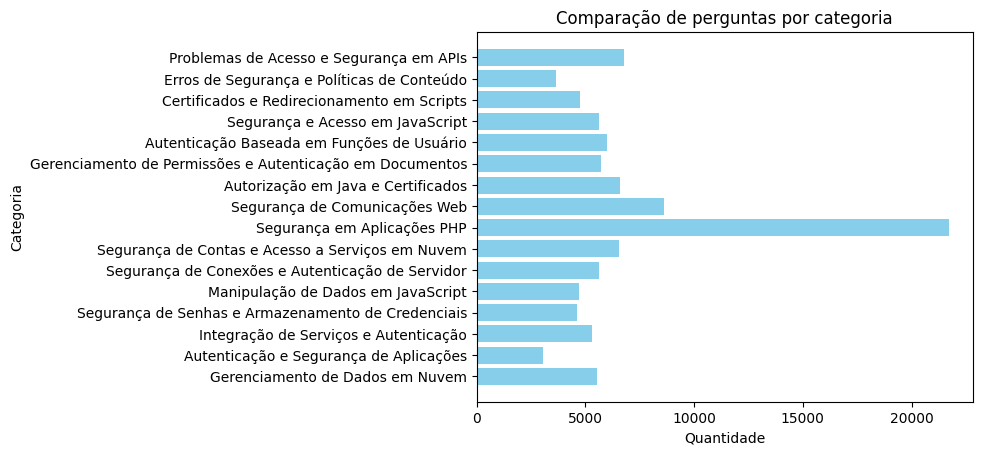

In [27]:
topic_questions_qtd = []

for i in range(1, 17):
    topic_questions_qtd.append(len(df_combined[df_combined["topic_assignment"] == i]))

print(topic_questions_qtd)

# Criar o gráfico de barras
plt.barh(gpt_labels, topic_questions_qtd, color='skyblue')

# Adicionar rótulos e título
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.title('Comparação de perguntas por categoria')

# Exibir o gráfico
plt.show()

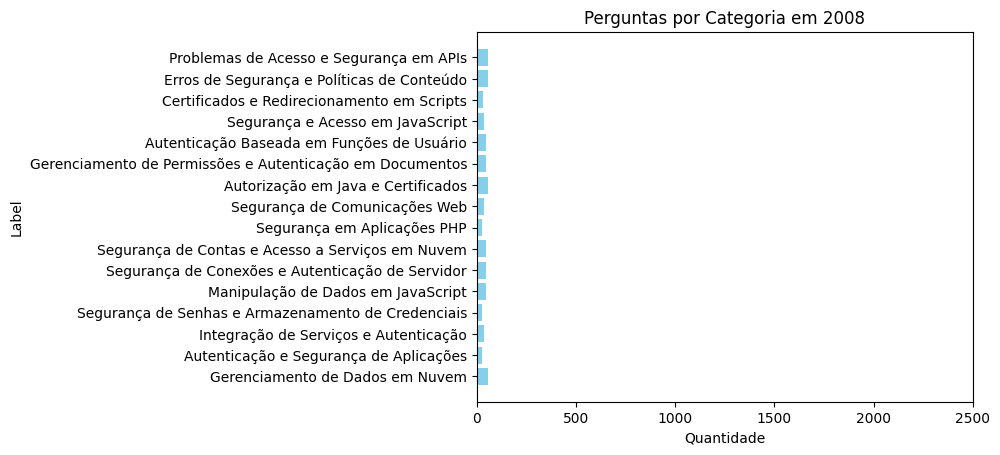

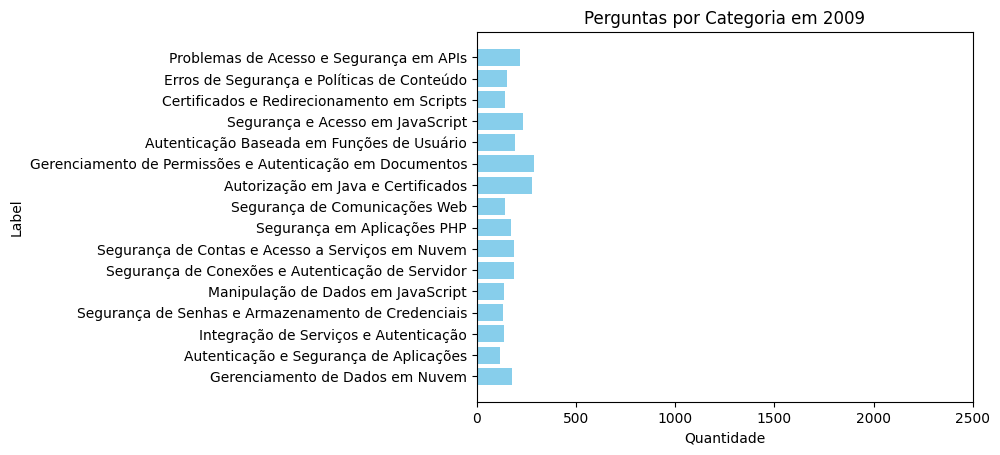

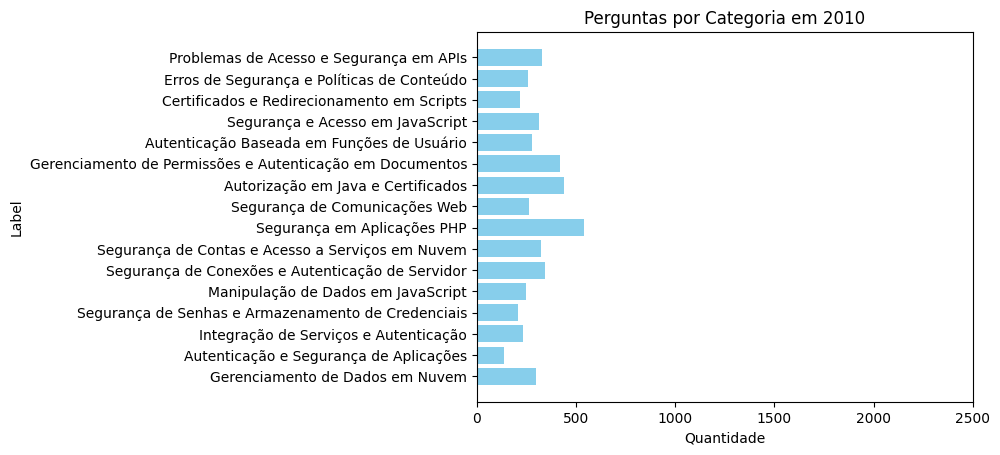

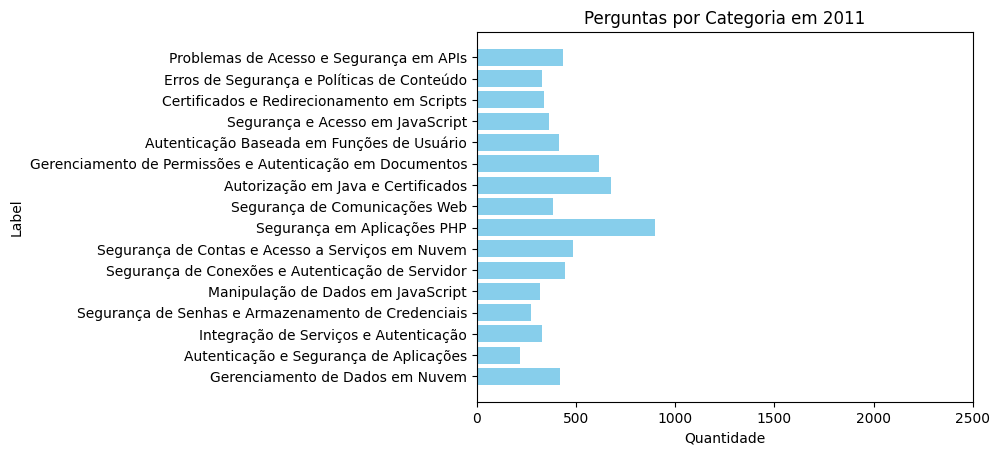

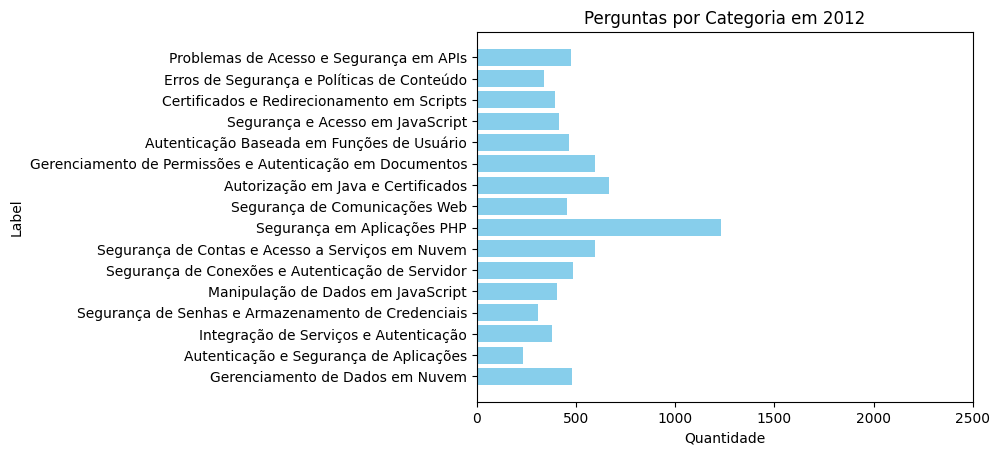

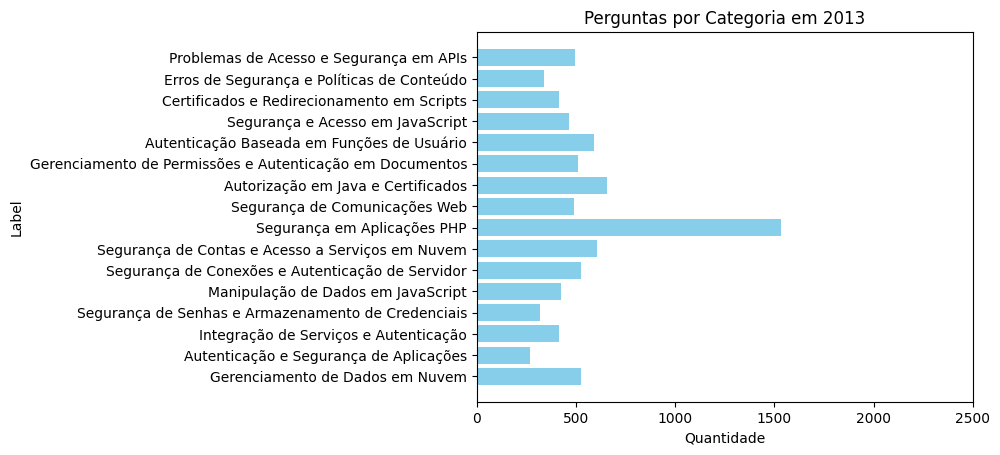

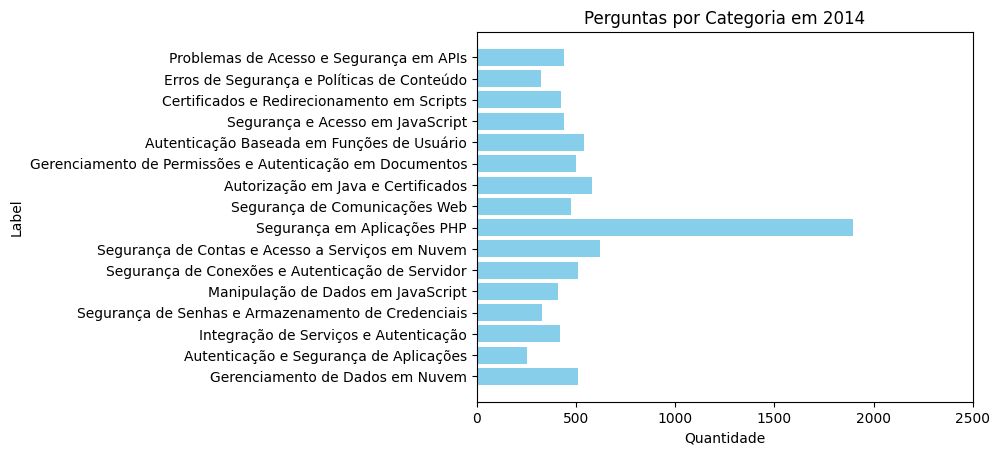

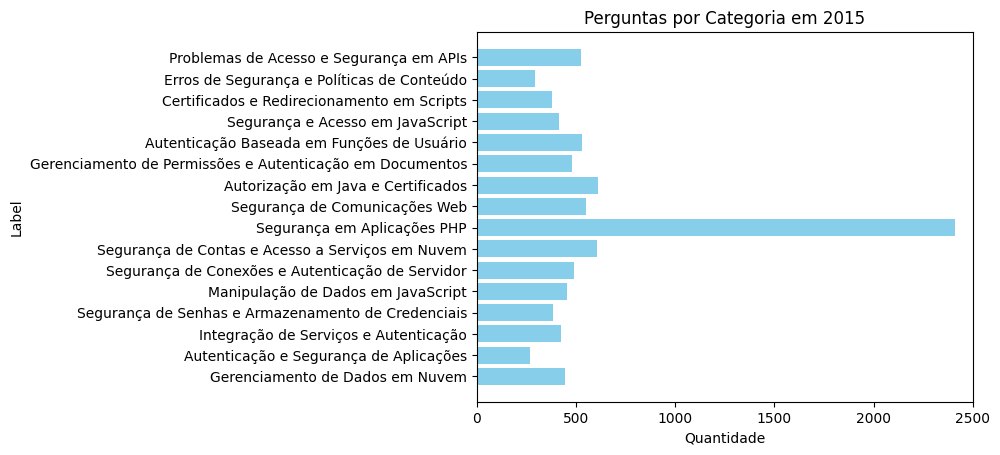

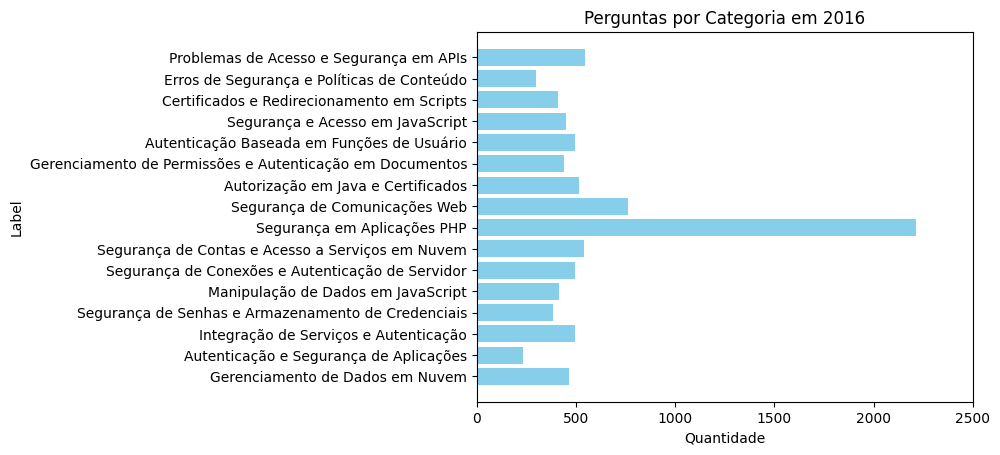

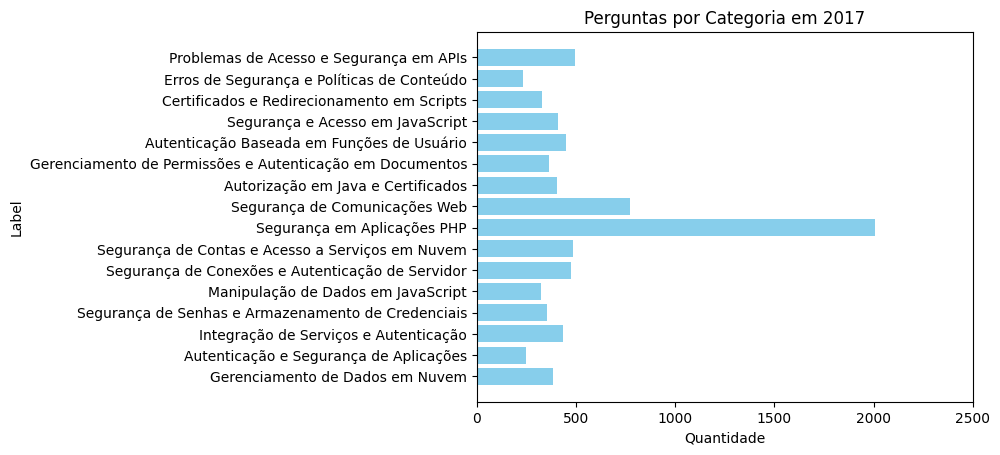

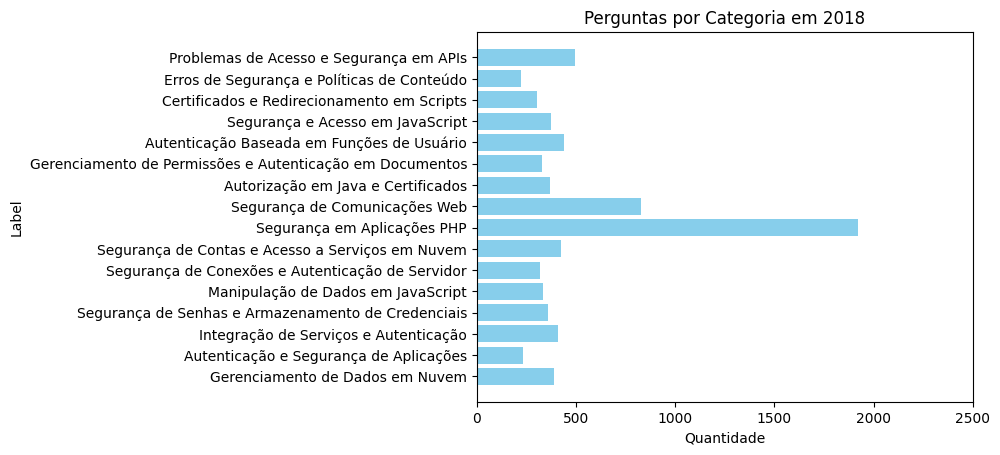

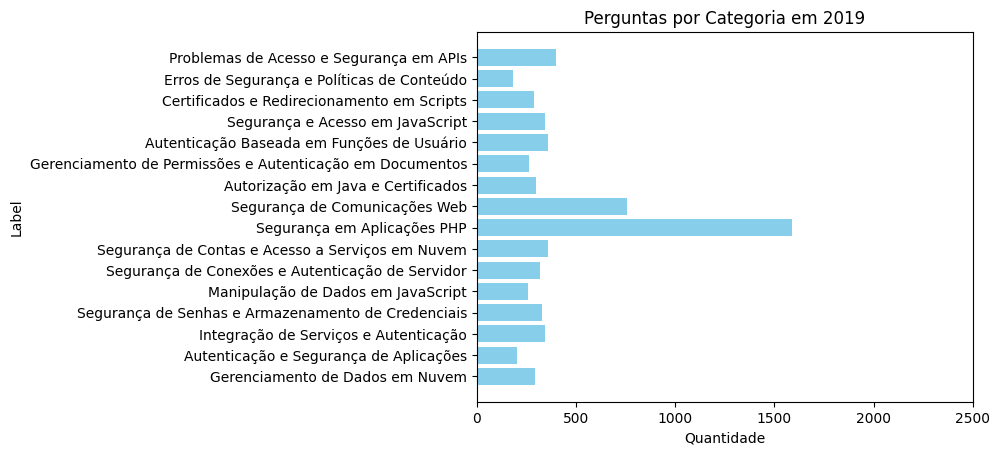

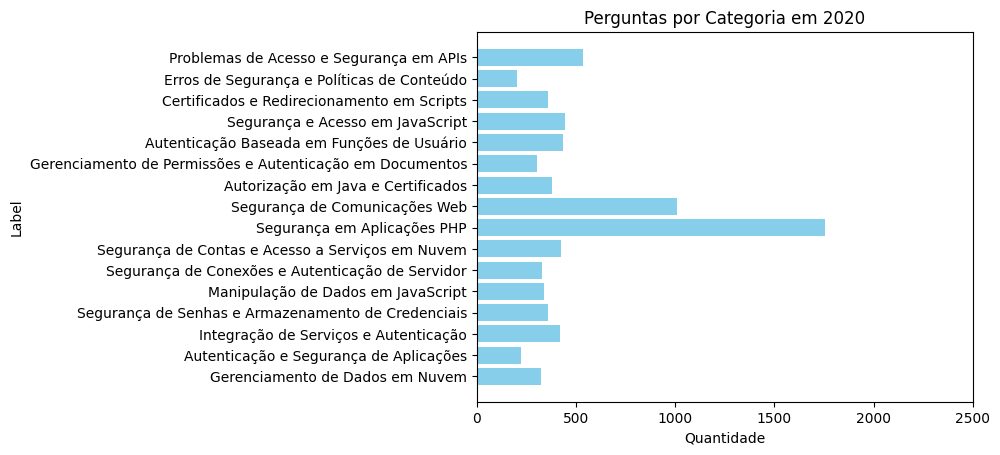

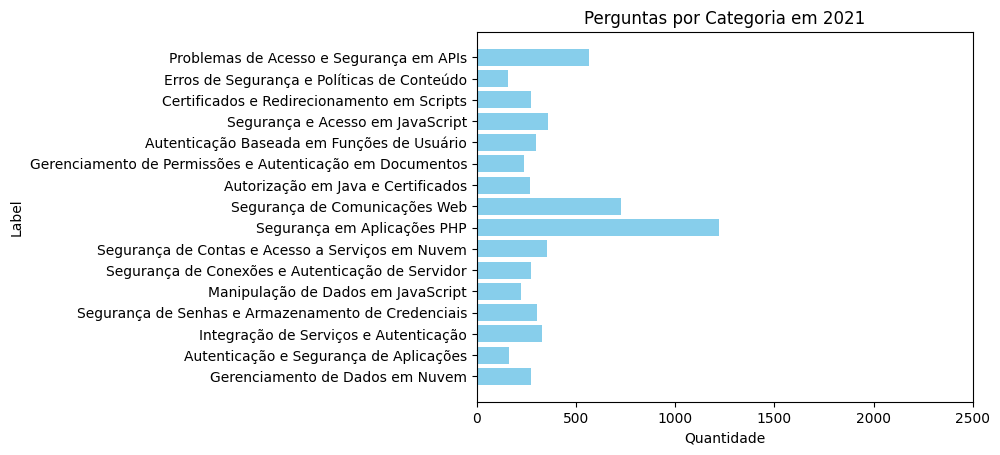

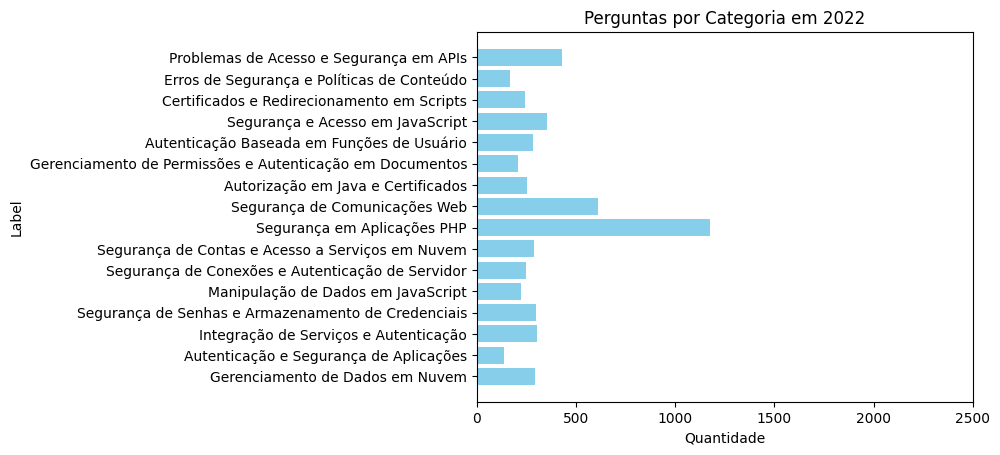

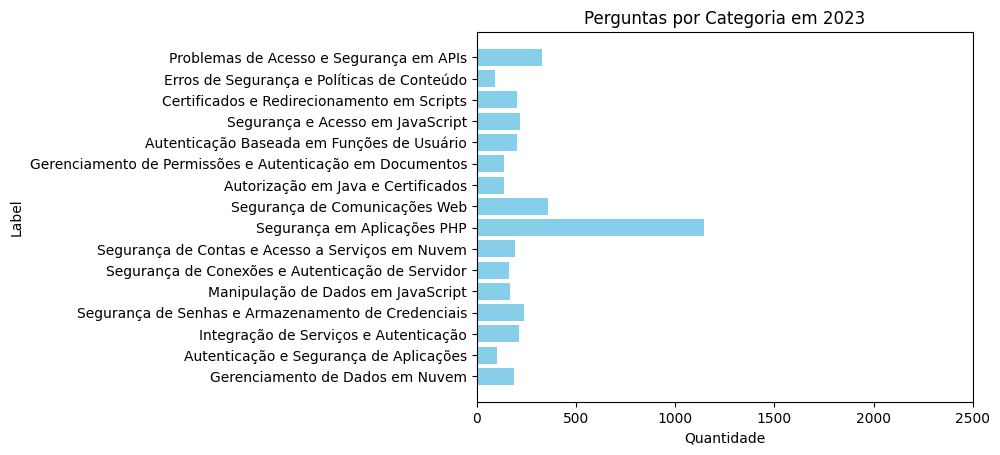

In [28]:
df_combined['DateTime'] = pd.to_datetime(df_combined['CreationDate'])

# Extraia o ano e adicione-o como uma nova coluna
df_combined['year'] = df_combined['DateTime'].dt.year

df_per_year = df_combined.groupby('year')
qtd_per_year = []

for ano, df_year in df_per_year:
    qtd = []
    qtd_per_year.append(len(df_year))
    for i in range(1, 17):
        qtd.append(len(df_year[df_year["topic_assignment"] == i]))
    
        # Criar o gráfico de barras
    plt.barh(gpt_labels, qtd, color='skyblue')

    plt.xlim(0, 2500)  

    # Adicionar rótulos e título
    plt.xlabel('Quantidade')
    plt.ylabel('Label')
    plt.title(f'Perguntas por Categoria em {ano}')

    # Exibir o gráfico
    plt.show()


[679, 2896, 4854, 6941, 7931, 8574, 8670, 9260, 9157, 8161, 7734, 6592, 7845, 6027, 5514, 4086]


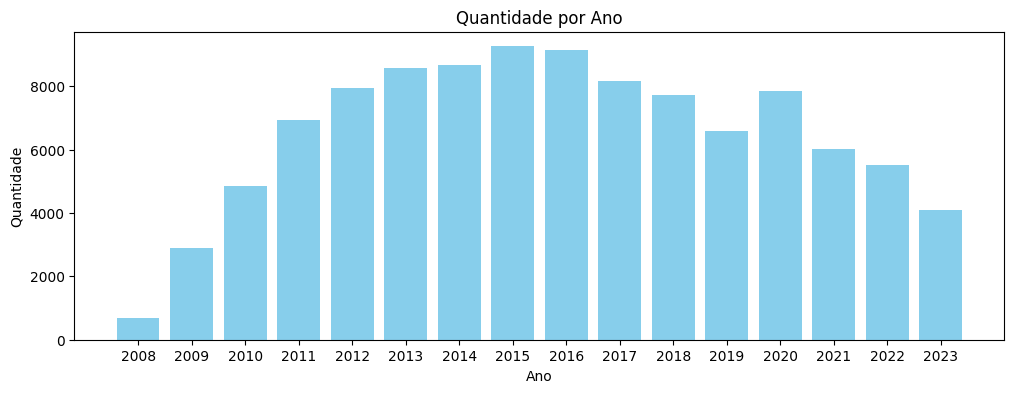

In [29]:
years = ["2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]
print(qtd_per_year)

# Criar o gráfico de barras
plt.figure(figsize=(12, 4))

plt.bar(years, qtd_per_year, color='skyblue')

# Adicionar rótulos e título
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.title(f'Quantidade por Ano')

# Exibir o gráfico
plt.show()